In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
import sklearn
print(sklearn.__version__)
print(pd.__version__)
print(np.__version__)

1.6.1
2.2.3
2.0.2


In [3]:
import os

# Establece la GPU a usar (en este caso la GPU #1)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#os.environ["CUDA_VISIBLE_DEVICES"] = "'0,1,2,3"

In [4]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

1


In [5]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2025-05-27 16:38:15.366744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748363895.384981 3786506 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748363895.390624 3786506 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 16:38:15.410346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
train = pd.read_csv("train_QSVM.csv")
test = pd.read_csv("test_QSVM.csv")

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#Eliminamos la primera columna, generada al pasar el conjunto de datos a formato csv.
train=train.drop(columns='Unnamed: 0')
test=test.drop(columns='Unnamed: 0')

train['proto'] = train['proto'].map({'TCP': 0, 'UDP': 1})
test['proto'] = test['proto'].map({'TCP': 0, 'UDP': 1})

In [4]:
porcentaje_mantener = 0.001

train_reducido_udp = train[train['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
train_reducido_tcp = train[train['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

train_reducido = pd.concat([train_reducido_udp, train_reducido_tcp])


test_reducido_udp = test[test['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
test_reducido_tcp = test[test['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

test_reducido = pd.concat([test_reducido_udp, test_reducido_tcp])

In [6]:
train_reducido['category'].value_counts()

category
Benign                 112
DDoS-HTTP_Flood        112
DDoS-UDP_Flood         112
DoS-UDP_Flood          112
Recon-HostDiscovery    112
Recon-OSScan           112
DDoS-SYN_Flood         112
Recon-PortScan         112
DoS-SYN_Flood          112
DoS-HTTP_Flood         111
Name: count, dtype: int64

In [8]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de prueba
X_test = test.drop(columns=['category'])
y_test= test['category']

In [5]:
X_train_reducido = train_reducido.drop(columns=['category'])
y_train_reducido = train_reducido['category']

X_test_reducido = test_reducido.drop(columns=['category'])
y_test_reducido = test_reducido['category']

In [ ]:
column_names = X_train.columns

#Normalización del conjunto de datos reducido
norm = StandardScaler()

X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)


pca = PCA(n_components=5)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [6]:
column_names = X_train_reducido.columns

#Normalización del conjunto de datos reducido
norm = StandardScaler()
X_train_reducido = norm.fit_transform(X_train_reducido)
X_test_reducido = norm.transform(X_test_reducido)

pca = PCA(n_components=20)
X_train_reducido = pca.fit_transform(X_train_reducido)
X_test_reducido = pca.transform(X_test_reducido)

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", #ibm_cloud
                               token='3aa94245772e1f158c23f72db59e301c40162b1807e98fb757bc1dc9e70f9f425f48bcfd6fe16305d02d332b18eae862e3ccdb625e5d6955141bbc6ad8aa26fa')

QiskitRuntimeService.save_account(channel='ibm_quantum',
                                  token='3aa94245772e1f158c23f72db59e301c40162b1807e98fb757bc1dc9e70f9f425f48bcfd6fe16305d02d332b18eae862e3ccdb625e5d6955141bbc6ad8aa26fa')

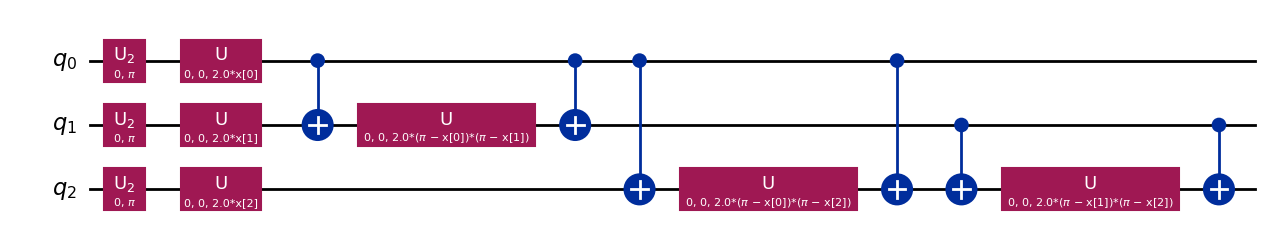

In [ ]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=3, reps=1)

feature_map.decompose().decompose().draw(output='mpl')

# Save the feature map representation
#plt.savefig('plots/feature_map_representation.png')

In [45]:
from qiskit_ibm_runtime import Session, SamplerV2, EstimatorV2
#from qiskit.providers.fake_provider import Fake127QPulseV1
#from qiskit_ibm_runtime.fake_provider import FakeBrisbane 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, QasmSimulator
#from qiskit_aer.primitives import SamplerV2

from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel, FidelityStatevectorKernel
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap

#service = QiskitRuntimeService()
#back = service.backend(name='ibm_brisbane')

num_qubits = X_train.shape[1]
backend = AerSimulator(method='statevector', device='GPU')#, noise_model=back)
session = Session(backend=backend)
pass_manager = generate_preset_pass_manager(optimization_level=0, target=backend.target)

sampler = SamplerV2(mode=session)
fidelity = ComputeUncompute(sampler=sampler, pass_manager=pass_manager)

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
qk = FidelityStatevectorKernel(feature_map=feature_map)

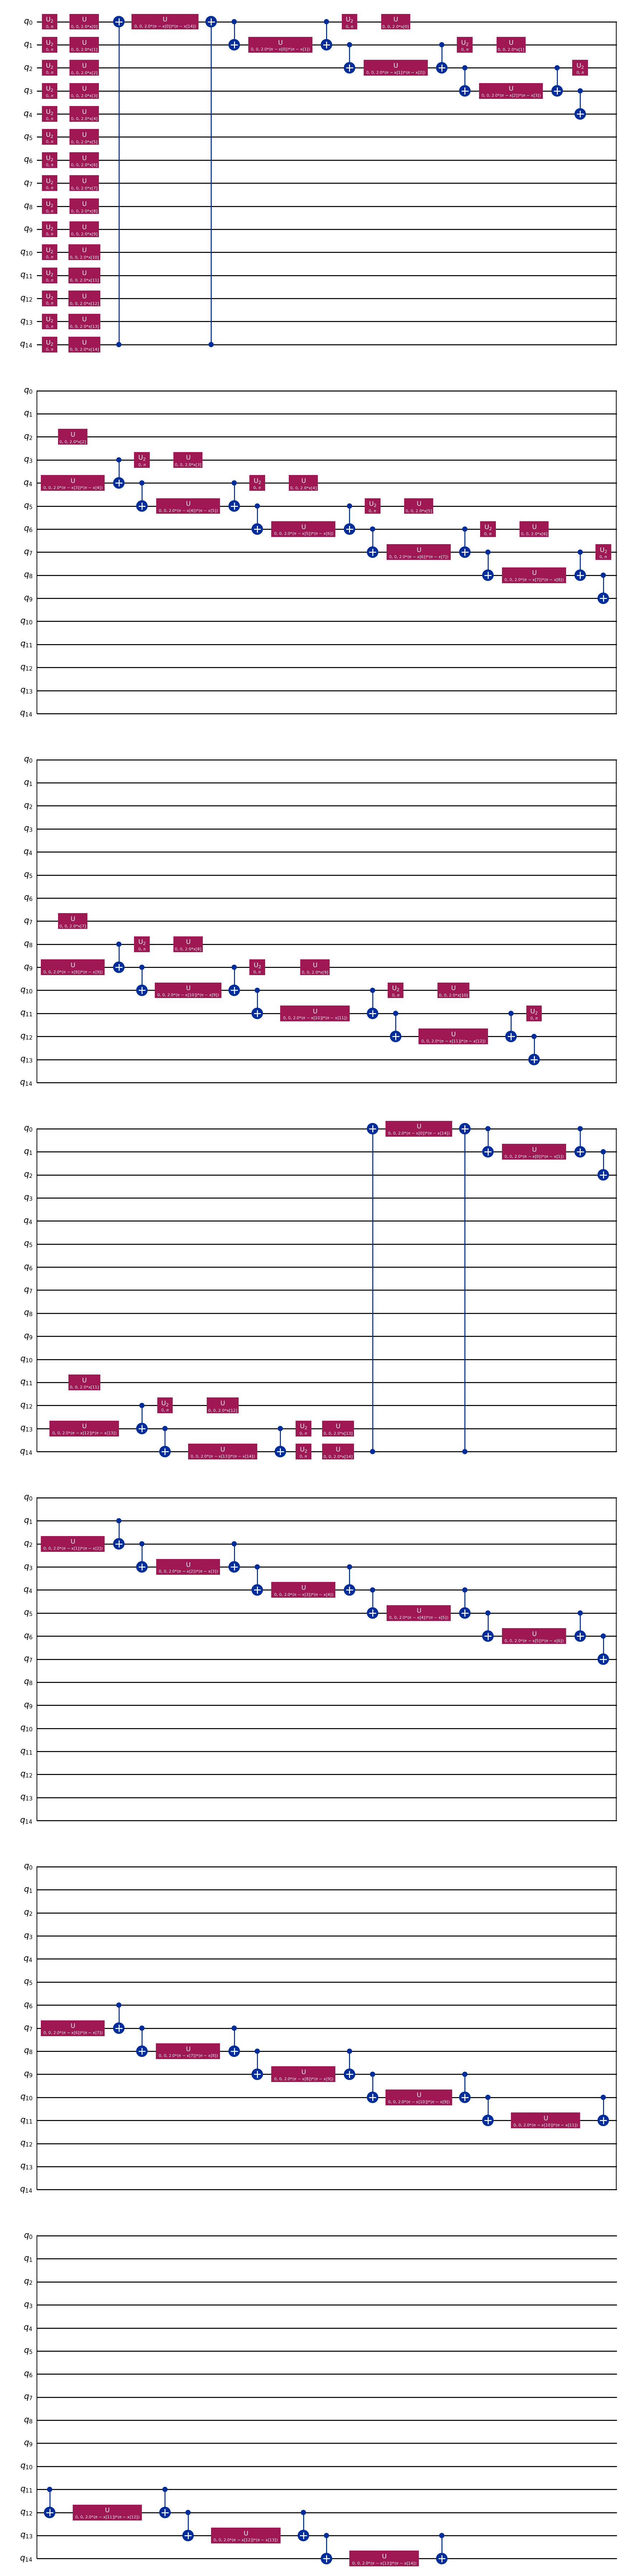

In [41]:
feature_map.decompose().decompose().draw(output='mpl')

In [16]:
# Verificar si se seleccionó GPU
print(f"Backend device: {backend.options.device}")

Backend device: GPU


In [17]:
import qiskit
import qiskit_machine_learning
import qiskit_aer
import qiskit_ibm_runtime
print(qiskit_ibm_runtime.__version__)
print(qiskit.__version__)
print(qiskit_machine_learning.__version__)
print(qiskit_aer.__version__)

0.35.0
1.3.2
0.8.2
0.15.1


In [10]:
from qiskit_machine_learning.algorithms import QSVC
import time

qsvc = QSVC(quantum_kernel=qk, C=1, random_state=42)

start = time.time()
qsvc.fit(X_train, y_train)
stop = time.time()

train_time = stop - start

start = time.time()
y_pred = qsvc.predict(X_test)
stop = time.time()

test_time = stop - start

print(f"Training Time: {train_time}")
print(f"Testing Time: {test_time}")
print(f"Total Time: {train_time + test_time}")
print(f"QSVC training score: {qsvc.score(X_train, y_train)}")
print('Precision en test: ', accuracy_score(y_test, y_pred))

Training Time: 35388.535014390945
Testing Time: 19194.76859807968
Total Time: 54583.30361247063
QSVC training score: 0.7470956210902592
Precision en test:  0.65625


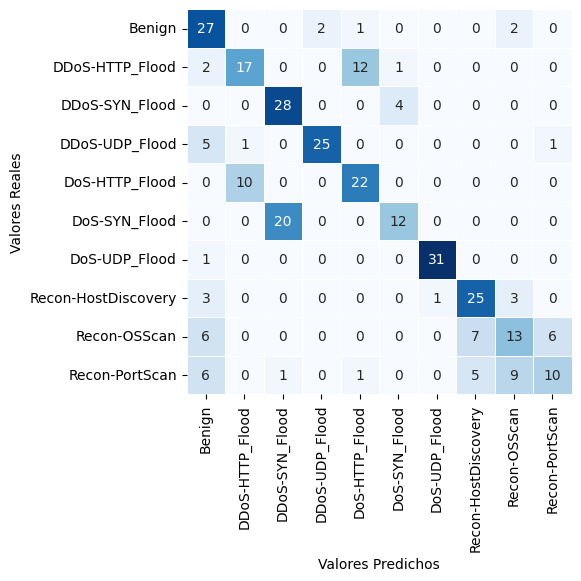

In [11]:
cm1 = confusion_matrix(y_test, y_pred)
normalized_matrix = cm1 #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

## Method 2: Precomputed Kernel

In [46]:
import time

start = time.time()
matrix_train = qk.evaluate(x_vec=X_train)
stop = time.time()

train_time = stop - start

In [47]:
start = time.time()
matrix_test = qk.evaluate(x_vec=X_test, y_vec=X_train)
stop = time.time()

test_time = stop - start

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GridSearchCV

SVM = SVC(kernel='precomputed', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(matrix_train, y_train)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)

SVM =  grid.best_estimator_
y_pred = SVM.predict(matrix_test)
print('Precision en test: ', accuracy_score(y_test, y_pred))

train_score = SVM.score(matrix_train, y_train)
test_score = SVM.score(matrix_test, y_test)

print(f"Training Time: {train_time}")
print(f"Testing Time: {test_time}")
print(f"Total Time: {train_time + test_time}")
print(f"Precomputed kernel classification training score: {train_score}")
print(f"Precomputed kernel classification test score: {test_score}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': np.float64(17.1)}
Best Cross Validation Score: 0.6558696348494555
Precision en test:  0.653125
Training Time: 484.1460053920746
Testing Time: 139.68884801864624
Total Time: 623.8348534107208
Precomputed kernel classification training score: 0.8570151921358355
Precomputed kernel classification test score: 0.653125


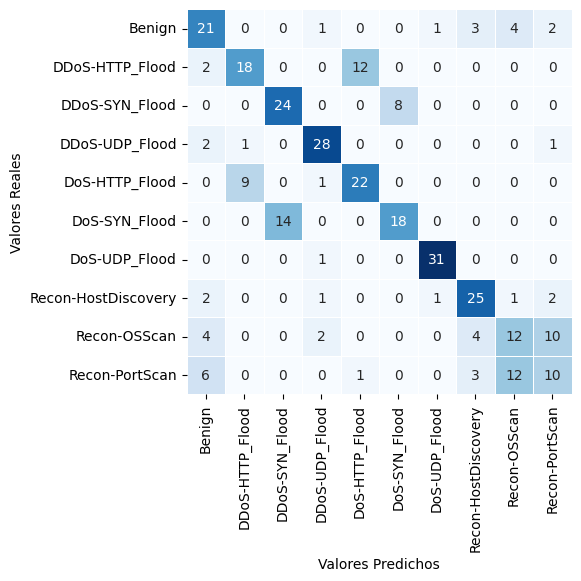

In [50]:
cm1 = confusion_matrix(y_test, y_pred)
normalized_matrix = cm1 #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()


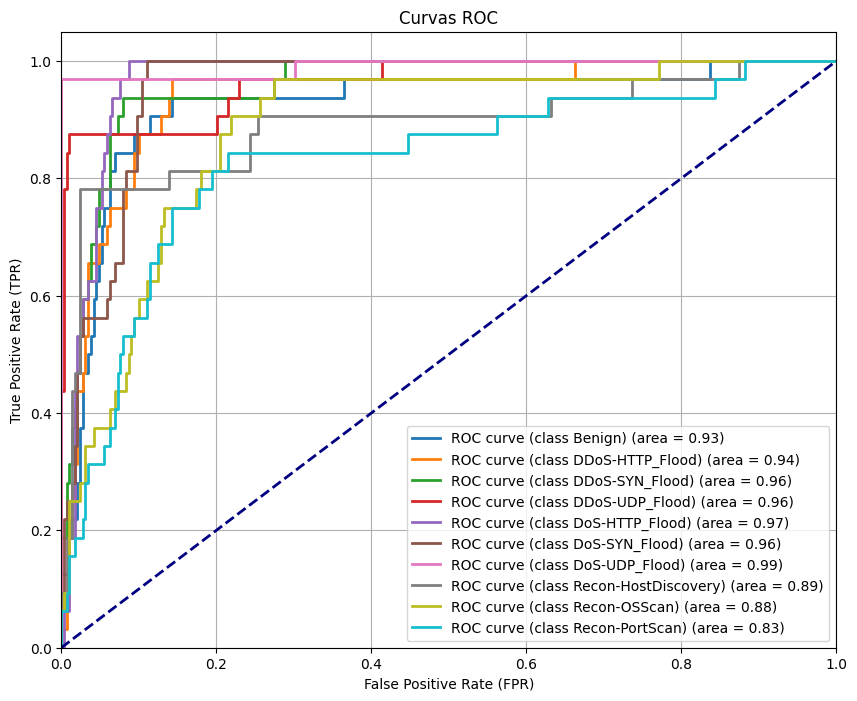

In [52]:
from sklearn.metrics import roc_curve, auc
y_score = SVM.decision_function(matrix_test)

# Binarizar las etiquetas
from sklearn.preprocessing import label_binarize
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
for class_label in classes:
    plt.plot(fpr[class_label], tpr[class_label], lw=2,
             label=f'ROC curve (class {class_label}) (area = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
